In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from typing import Union
from PIL import Image
from torch import Tensor

In [2]:
root_dir_test = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/test'

data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)
testloader = DataLoader(test_image_dataset, batch_size=128, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('/Users/vionnietan/Desktop/resnet18.pth')
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
class_names = testloader.dataset.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            image = image.numpy().transpose((1, 2, 0))
            
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)
            
            colour = 'green' if preds[i] == labels[i] else 'red'
            plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
    plt.tight_layout()        
    plt.show()

In [29]:
def show_preds():
    model.eval()    # set to evaluation mode
    images, labels = next(iter(testloader))
    outputs = model(images)
    _ , preds = torch.max(outputs, 1)
    #print(labels)
    show_images(images, labels, preds)

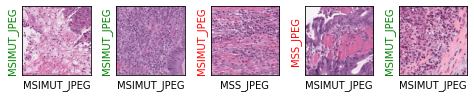

In [30]:
show_preds()

In [7]:
def predict_image(image):
    image_tensor = data_transformation_test(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(root_dir_test, transform=data_transformation_test)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

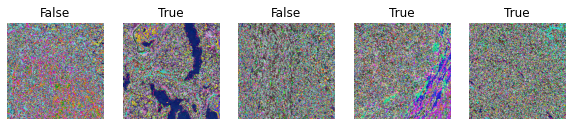

In [8]:
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [31]:
def to_numpy(tensor: Union[Tensor, Image.Image, np.array]) -> np.ndarray:
    if type(tensor) == np.array or type(tensor) == np.ndarray:
        return np.array(tensor)
    elif type(tensor) == Image.Image:
        return np.array(tensor)
    elif type(tensor) == Tensor:
        return tensor.cpu().detach().numpy()
    else:
        raise ValueError()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            prediction = outputs.argmax(dim=1, keepdim=True)
            actuals.extend(to_numpy(labels.view_as(prediction)))
            predictions.extend(to_numpy(prediction))
            
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('Confusion matrix for resnet18: ')
print(confusion_matrix(actuals, predictions))
print('AUC score for model resnet18: '+str(roc_auc_score(actuals,predictions)))

Confusion matrix for resnet18: 
[[8 1 1]
 [9 1 0]
 [0 0 0]]
AUC score for model resnet18: 0.44500000000000006
